In [1]:
import math
import torch
import gpytorch
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

from GPyEm import GPE_ensemble as GPE

import os
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split


seed = 7
#set_seed(seed)

In [77]:
mesh=40
filename = "MCMC_output_mesh"+str(mesh)+".h5"
# y_val= [A_TAT,V_TAT]
y_val = torch.tensor([134,134])

In [3]:
x_labels=pd.read_csv(r'/Users/pmzcwl/Library/CloudStorage/OneDrive-TheUniversityofNottingham/shared_simulations/EP/scenario_13/xlabels.txt',delim_whitespace=True,header=None)


X_all = pd.read_csv(r'/Users/pmzcwl/Library/CloudStorage/OneDrive-TheUniversityofNottingham/shared_simulations/EP/scenario_'+str(mesh)+'/X.txt',index_col=None,delim_whitespace=True,header=None)
X_all.columns=x_labels.values.squeeze().tolist()
print(X_all)

     CV_ventricles  k_ventricles    k_FEC  CV_atria   k_atria     k_BB
0         0.606444      0.442714  5.53288  0.317814  0.376440  1.35358
1         0.518476      0.304389  6.83032  0.628421  0.237364  1.25791
2         0.641101      0.239081  5.82181  1.020680  0.437033  5.30559
3         0.750099      0.373713  4.49537  0.526532  0.444927  2.07317
4         0.689263      0.388615  2.34609  0.556797  0.477035  2.36587
..             ...           ...      ...       ...       ...      ...
115       0.545148      0.260282  1.41140  0.982380  0.242211  2.02864
116       0.407284      0.272427  1.55631  0.353259  0.340049  1.65963
117       0.796166      0.465371  7.16628  0.539272  0.228129  1.68568
118       0.752534      0.476168  3.40841  0.386740  0.264407  5.40274
119       0.687991      0.318799  6.32706  0.767307  0.234231  4.38626

[120 rows x 6 columns]


In [4]:
y_labels=pd.read_csv(r'/Users/pmzcwl/Library/CloudStorage/OneDrive-TheUniversityofNottingham/shared_simulations/EP/scenario_13/ylabels.txt',delim_whitespace=True,header=None)


y_all = pd.read_csv(r'/Users/pmzcwl/Library/CloudStorage/OneDrive-TheUniversityofNottingham/shared_simulations/EP/scenario_'+str(mesh)+'/Y.txt',index_col=None,delim_whitespace=True,header=None)
y_all.columns=y_labels.values.squeeze().tolist()
print(y_all)

        A_TAT     V_TAT
0    326.3430  100.5180
1    183.9530  130.7160
2     78.6365  115.3240
3    174.7200   86.9669
4    159.2430   95.3313
..        ...       ...
115  107.5570  140.7120
116  284.2610  182.8520
117  205.9150   73.8898
118  239.8420   80.7692
119  125.1910   97.1398

[120 rows x 2 columns]


# Emulator

In [5]:
y_all.max()

A_TAT    352.723
V_TAT    200.881
dtype: float64

In [6]:
input_masked = X_all.copy()

In [7]:
y_all

,A_TAT,V_TAT
0,326.3430,100.5180
1,183.9530,130.7160
2,78.6365,115.3240
3,174.7200,86.9669
4,159.2430,95.3313
...,...,...
115,107.5570,140.7120
116,284.2610,182.8520
117,205.9150,73.8898
118,239.8420,80.7692


In [8]:
y_train = torch.tensor(y_all.values)
x_train = torch.tensor(X_all[0:y_all.shape[0]].values)

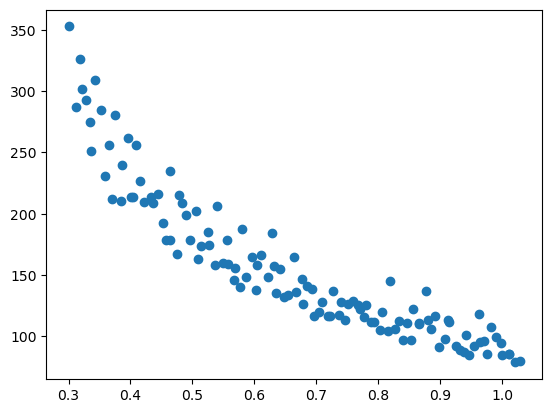

In [9]:
plt.plot(x_train[:,3],y_train[:,0],'o')

In [10]:
y_train

tensor([[326.3430, 100.5180],
        [183.9530, 130.7160],
        [ 78.6365, 115.3240],
        [174.7200,  86.9669],
        [159.2430,  95.3313],
        [159.4960,  85.7816],
        [111.5320, 160.8760],
        [128.2950, 126.4680],
        [ 85.2694,  95.2810],
        [ 96.5890, 133.9790],
        [122.4770, 101.4700],
        [209.7640, 123.8980],
        [ 96.7988, 122.7850],
        [119.8950, 164.1450],
        [116.8980, 114.6310],
        [192.3800,  90.0702],
        [164.9690,  84.7386],
        [126.4440, 105.3290],
        [208.7870, 200.8810],
        [110.6070,  84.1817],
        [ 85.8296,  94.4645],
        [ 94.2734, 133.3010],
        [308.7260, 152.8160],
        [185.4290, 141.9500],
        [ 87.5541, 118.7400],
        [292.7550, 122.8820],
        [111.8240, 163.7690],
        [ 79.7282, 104.8940],
        [118.5210,  93.8477],
        [135.1400, 150.6880],
        [133.8990, 105.4380],
        [213.3040, 112.7240],
        [105.2660,  88.9114],
        [1

In [11]:
x_train.shape

torch.Size([120, 6])

In [12]:
emulator = GPE.ensemble(x_train,y_train,mean_func="linear",training_iter=500)

0
1


In [13]:
nDim = input_masked.shape[1]
boundsMaxMin = []
for i in range(nDim):
    boundsMaxMin.append([np.min(input_masked.iloc[:,i]),np.max(input_masked.iloc[:,i])])
    print(boundsMaxMin[i])

[0.382351, 0.799717]
[0.201679, 0.499831]
[1.24091, 8.38479]
[0.300623, 1.02851]
[0.200837, 0.497599]
[1.01838, 5.67135]


In [14]:
##### from SALib.sample import saltelli
from SALib.sample import saltelli
from SALib.analyze import sobol
from SALib.test_functions import Ishigami
import numpy as np

# Define the model inputs
problem = {
    'num_vars': nDim,
    'names': x_labels,
    'bounds': boundsMaxMin
    #'bounds': [[-1, 1],
     #          [-1, 1],
      #         [-1, 1],
       #        [-1, 1],
        #       [-1, 1],
         #      [-1, 1],
          #     [-1, 1],
           #    [-1, 1],
            #   [-1,1]]
}

# Generate samples
param_values = saltelli.sample(problem, 1024)

data1 = torch.tensor(param_values)
#data1.columns = X_train.columns

Ymean=emulator.predict(data1)

/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_23878/2553582652.py:24: DeprecationWarning: `salib.sample.saltelli` will be removed in SALib 1.5. Please use `salib.sample.sobol`
  param_values = saltelli.sample(problem, 1024)


In [15]:
data1.shape

torch.Size([14336, 6])

In [16]:
Si = []
nMod = y_all.shape[1]
nDim = input_masked.shape[1]
for i in range(nMod):
    Si.append(sobol.analyze(problem, Ymean[:,i].detach().numpy(), print_to_console=True,calc_second_order=True))

                        ST   ST_conf
(CV_ventricles,)  0.000056  0.000010
(k_ventricles,)   0.000071  0.000014
(k_FEC,)          0.000255  0.000057
(CV_atria,)       0.936558  0.062376
(k_atria,)        0.026816  0.003018
(k_BB,)           0.040096  0.004600
                        S1   S1_conf
(CV_ventricles,)  0.000020  0.000691
(k_ventricles,)   0.000050  0.000706
(k_FEC,)          0.000061  0.001352
(CV_atria,)       0.930894  0.081300
(k_atria,)        0.022779  0.015000
(k_BB,)           0.035033  0.017433
Empty DataFrame
Columns: [S2, S2_conf]
Index: []
                        ST   ST_conf
(CV_ventricles,)  0.857332  0.051397
(k_ventricles,)   0.133781  0.013112
(k_FEC,)          0.015838  0.001987
(CV_atria,)       0.000186  0.000057
(k_atria,)        0.000628  0.000196
(k_BB,)           0.000042  0.000006
                        S1   S1_conf
(CV_ventricles,)  0.850614  0.065455
(k_ventricles,)   0.127827  0.031229
(k_FEC,)          0.013241  0.010980
(CV_atria,)      -0.000162

In [17]:
Si_first=np.zeros((nDim,nMod))
Si_total=np.zeros((nDim,nMod))
for i in range(nMod):
    total_Si, first_Si, second_Si = Si[i].to_df()
    Si_first[:,i] =  first_Si.iloc[:,0]
    Si_total[:,i] =  total_Si.iloc[:,0]


In [18]:
x_labels.values.squeeze().tolist()

['CV_ventricles', 'k_ventricles', 'k_FEC', 'CV_atria', 'k_atria', 'k_BB']

In [19]:
y_all.columns.tolist()

['A_TAT', 'V_TAT']

In [20]:
['PCa_b',
 'Tref',
 'perm50',
 'CV_ventricles',
 'a_ventricles',
 'EDP_lv',
 'EDP_rv',
 'Rsys',
 'Rpulm']

['PCa_b',
 'Tref',
 'perm50',
 'CV_ventricles',
 'a_ventricles',
 'EDP_lv',
 'EDP_rv',
 'Rsys',
 'Rpulm']

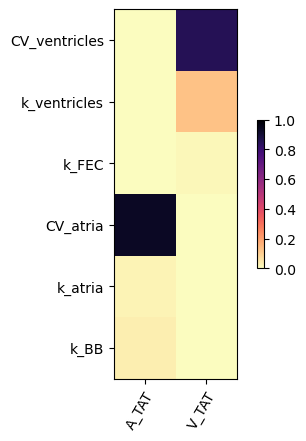

In [21]:
inputs = X_all.columns.tolist()
outputs = y_all.columns.tolist()
fig, ax = plt.subplots()
im = ax.imshow(Si_first[0:28],cmap='magma_r',vmin=0,vmax=1)

ax.set_xticks(np.arange(len(outputs)),labels=outputs)
ax.set_yticks(np.arange(len(inputs)), labels=inputs)
plt.setp(ax.get_xticklabels(), rotation=60, ha="right",
         rotation_mode="anchor");

plt.colorbar(im,fraction=0.015, pad=0.04)

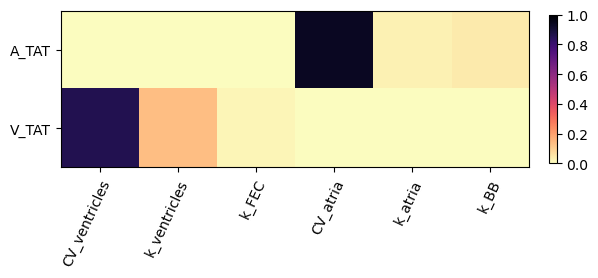

In [22]:
inputs = X_all.columns.tolist()
outputs = y_all.columns.tolist()
fig, ax = plt.subplots()
im = ax.imshow(Si_total.T[0:28],cmap='magma_r',vmin=0,vmax=1)

ax.set_yticks(np.arange(len(outputs)),labels=outputs)
ax.set_xticks(np.arange(len(inputs)), labels=inputs)
plt.setp(ax.get_xticklabels(), rotation=65, ha="right",
         rotation_mode="anchor");

plt.colorbar(im,fraction=0.015, pad=0.04)

In [23]:
centre = (np.array(boundsMaxMin)[:,1]+np.array(boundsMaxMin)[:,0])/2

In [24]:
boundsMaxMin

[[0.382351, 0.799717],
 [0.201679, 0.499831],
 [1.24091, 8.38479],
 [0.300623, 1.02851],
 [0.200837, 0.497599],
 [1.01838, 5.67135]]

In [25]:
boundsMaxMin=np.array(boundsMaxMin)

In [26]:
np.array(boundsMaxMin)[[0,3],0]

array([0.382351, 0.300623])

In [27]:
np.array(boundsMaxMin)[[0,3],1]

array([0.799717, 1.02851 ])

In [28]:
def log_prior(theta):
    
    #if (np.array(boundsMaxMin)[:,0]<theta).all() and (theta<np.array(boundsMaxMin)[:,1]).all():
        
    if (np.array(boundsMaxMin)[[0,3],0]<theta).all() and (theta<np.array(boundsMaxMin)[[0,3],1]).all():

        return 0.0
    return -np.inf

In [29]:
def log_likelihood(x,emulator,y_val,obs_error,fix_loc):
    #x=torch.tensor(x)[None]
    test=fix_loc.copy()
    test[:,0]=x[0]
    test[:,3]=x[1]
    
    with gpytorch.settings.fast_pred_var(): #This line makes it fast!
        ll =np.sum((emulator.ensemble_log_likelihood_obs_error(torch.tensor(test),y_val[None],obs_error)).detach().numpy())
    return ll

In [30]:
def log_prob(theta, emulator,y_val,obs_error,fix_loc):
    
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    
    return lp + log_likelihood(theta,emulator, y_val,obs_error,fix_loc)

In [31]:
import emcee

In [32]:
centre = (np.array(boundsMaxMin)[:,1]+np.array(boundsMaxMin)[:,0])/2
ndim = 2
nwalkers = 8
p0 = np.random.uniform(0,1,(nwalkers,ndim))*(np.array(boundsMaxMin)[[0,3],1]-np.array(boundsMaxMin)[[0,3],0])+np.array(boundsMaxMin)[[0,3],0]
#y_val = torch.tensor([80,134])
obs_error=((y_val*0.05))**2

In [33]:
y_val+2*((y_val*0.05))

tensor([147.4000, 147.4000])

In [34]:
boundsMaxMin

array([[0.382351, 0.799717],
       [0.201679, 0.499831],
       [1.24091 , 8.38479 ],
       [0.300623, 1.02851 ],
       [0.200837, 0.497599],
       [1.01838 , 5.67135 ]])

In [35]:
obs_error

tensor([44.8900, 44.8900])

In [36]:
fix_loc=centre[None]

In [52]:
# Set up the backend
# Don't forget to clear it in case the file already exists

backend = emcee.backends.HDFBackend(filename)
backend.reset(nwalkers, ndim)

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_prob, args=[emulator,y_val,obs_error,fix_loc], backend=backend)



In [53]:
sampler.run_mcmc(p0, 40000,progress=True)

100%|█████████████████████████████████████| 40000/40000 [11:21<00:00, 58.67it/s]


State([[0.5039372  0.67807802]
 [0.46089466 0.68265817]
 [0.47512743 0.63690646]
 [0.50720488 0.71140375]
 [0.51679175 0.65911929]
 [0.45101098 0.69042675]
 [0.49742684 0.63101486]
 [0.49673053 0.67672343]], log_prob=[-5.85172415 -6.78030062 -6.28305817 -6.72551107 -6.12061214 -7.68692303
 -6.17705154 -5.74557257], blobs=None, random_state=('MT19937', array([ 962420593, 2555825972, 1372182216, 3228576692, 2500313781,
       1310873418, 2484671376, 1567350183, 2781934090, 1346229982,
       2401803800, 2363723878, 3339779999, 3417593309, 3469988052,
       4101366442,  959526929, 3790442701,  333559960,  324352988,
       1598961622, 3330308689,   94127529, 3671671154, 1807130600,
       3128237465,  349435813, 2597279360, 3996824568,  398277112,
       4025405431, 4170635155, 2293353509, 4222909880,  277308524,
         35903941,   78256825, 1652210749, 1419479023, 3874146163,
        291148973, 3347579207,   25309134,  109875491, 1069733003,
       3177943004, 1413145216,   44214632, 

In [79]:
import corner

tau = sampler.get_autocorr_time()
burnin = int(2 * np.max(tau))
thin = int(0.5 * np.min(tau))
samples = sampler.get_chain(discard=burnin, flat=True, thin=thin)
log_prob_samples = sampler.get_log_prob(discard=burnin, flat=True, thin=thin)
#log_prior_samples = sampler.get_blobs(discard=burnin, flat=True, thin=thin)

print("burn-in: {0}".format(burnin))
print("thin: {0}".format(thin))
print("flat chain shape: {0}".format(samples.shape))

burn-in: 78
thin: 17
flat chain shape: (18784, 2)


In [66]:
flat_samples = sampler.get_chain(discard=20000, thin=10, flat=True)
print(flat_samples.shape)

(16000, 2)


In [67]:
boundsMaxMin

array([[0.382351, 0.799717],
       [0.201679, 0.499831],
       [1.24091 , 8.38479 ],
       [0.300623, 1.02851 ],
       [0.200837, 0.497599],
       [1.01838 , 5.67135 ]])

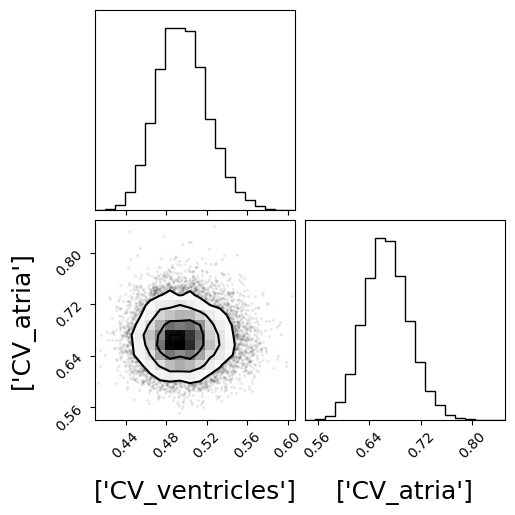

In [78]:
import corner

fig = corner.corner(
    flat_samples, labels=x_labels.values[[0,3]], label_kwargs=dict(fontsize=18)
);

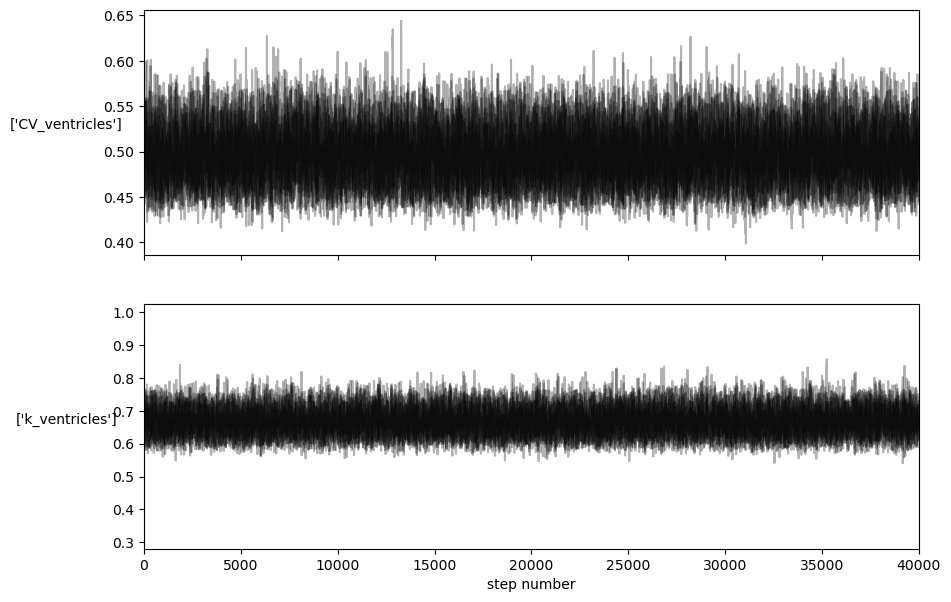

In [63]:
fig, axes = plt.subplots(ndim, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = x_labels.values
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i],rotation=0)
    ax.yaxis.set_label_coords(-0.1, 0.5)


axes[-1].set_xlabel("step number");

In [46]:
test=torch.tensor(centre)
test[0]=flat_samples.mean(axis=0)[0]
test[3]=flat_samples.mean(axis=0)[1]
emulator.predict(test[None])

tensor([[133.2010, 132.9438]], grad_fn=<PermuteBackward0>)

In [47]:
flat_samples.mean(axis=0)

array([0.49646661, 0.66785345])

In [48]:
flat_samples.std(axis=0)

array([0.02497861, 0.0346214 ])

In [49]:
flat_samples.mean(axis=0)-flat_samples.std(axis=0)

array([0.471488  , 0.63323205])

In [50]:
flat_samples.mean(axis=0)+flat_samples.std(axis=0)

array([0.52144523, 0.70247484])

In [51]:
boundsMaxMin.T

array([[0.382351, 0.201679, 1.24091 , 0.300623, 0.200837, 1.01838 ],
       [0.799717, 0.499831, 8.38479 , 1.02851 , 0.497599, 5.67135 ]])

In [75]:
reader = emcee.backends.HDFBackend('test.h5')

tau = reader.get_autocorr_time()
burnin = int(2 * np.max(tau))
thin = int(0.5 * np.min(tau))
samples = reader.get_chain(discard=burnin, flat=True, thin=thin)

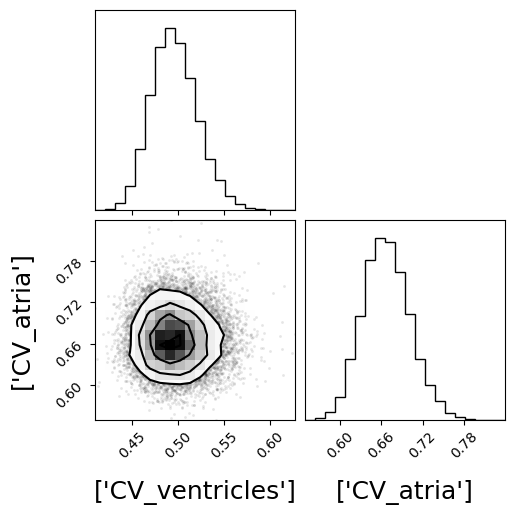

In [76]:
import corner

fig = corner.corner(
    samples, labels=x_labels.values[[0,3]], label_kwargs=dict(fontsize=18)
);